In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from collections import defaultdict
from sklearn.utils import resample
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
import usefulFunctions as useful
import eval_functions as metrics

In [2]:
fileName = "Master_PL.xlsx - Master_PL.csv"
normalized_table = pd.read_csv(fileName, header=0, 
                    names=["id", "type", "gender", "age", "monthsFromScreening", "protein_BL", "protein_V4",
                          "protein_V6", "protein_V8", "protein_V10", "protein_V12"])

In [3]:
normalized_table

,id,type,gender,age,monthsFromScreening,protein_BL,protein_V4,protein_V6,protein_V8,protein_V10,protein_V12
0,3011,1,2,32,NaN,26.0,NaN,NaN,NaN,NaN,NaN
1,3016,1,2,58,NaN,66.0,67.00,70.00,56.00,NaN,NaN
2,3069,1,1,54,NaN,24.0,34.00,32.00,30.00,33.0,NaN
3,3072,1,1,47,NaN,44.0,55.00,37.00,NaN,40.0,37.0
4,3073,1,2,48,NaN,68.0,64.00,77.00,NaN,65.0,79.0
5,3074,1,2,31,NaN,40.0,42.00,43.00,44.00,43.0,NaN
6,3085,1,2,57,NaN,55.0,52.00,48.00,57.00,NaN,NaN
7,3087,1,2,57,NaN,45.0,50.00,NaN,NaN,NaN,NaN
8,3109,1,2,53,NaN,37.0,52.00,41.00,48.00,41.0,NaN
9,3151,1,2,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def make_binary(x):
    return x-1

def make_boolean(x):
    if x:
        return bool(x)
    else:
        return bool(x)
def standardize(x, mean, std):
    return (x - mean)/std

def support(column):
    counts = defaultdict(int)
    
    for value in column:
        counts[value]+=1
    
    for key in counts:
        counts[key] = counts[key]/float(len(column))
    
    return counts

In [22]:
normalized_table.type = normalized_table.type.apply(make_binary)
normalized_table.gender = normalized_table.gender.apply(make_binary)

In [23]:
age_mean = np.mean(normalized_table.age)
age_std = np.std(normalized_table.age)

monthsFromScreening_mean = np.mean(normalized_table.monthsFromScreening)
monthsFromScreening_std = np.std(normalized_table.monthsFromScreening)

In [24]:
normalized_table.age = normalized_table.age.apply(lambda x: standardize(x, age_mean, age_std))
normalized_table.monthsFromScreening = normalized_table.monthsFromScreening.apply(lambda x: standardize(x, 
                                                                                             monthsFromScreening_mean,\
                                                                                             monthsFromScreening_std))

In [25]:
normalized_table = normalized_table[(normalized_table.protein_BL > 5) & (normalized_table.protein_V4 > 5) & (normalized_table.protein_V6 > 5) & 
             (normalized_table.protein_V8 > 5)]

len(normalized_table)
normalized_table.type.value_counts()

1    190
0     84
Name: type, dtype: int64

In [158]:
normalized_table = normalized_table[(normalized_table.protein_BL > 5) & (normalized_table.protein_V4 > 5) & (normalized_table.protein_V6 > 5) & 
             (normalized_table.protein_V8 > 5)]

In [26]:
bl_mean = np.mean(normalized_table.protein_BL)
bl_std = np.std(normalized_table.protein_BL)

v4_mean = np.mean(normalized_table.protein_V4)
v4_std = np.std(normalized_table.protein_V4)

v6_mean = np.mean(normalized_table.protein_V6)
v6_std = np.std(normalized_table.protein_V6)

v8_mean = np.mean(normalized_table.protein_V8)
v8_std = np.std(normalized_table.protein_V8)

v10_mean = np.mean(normalized_table.protein_V10)
v10_std = np.std(normalized_table.protein_V10)

v12_mean = np.mean(normalized_table.protein_V12)
v12_std = np.std(normalized_table.protein_V12)

normalized_table.protein_BL = normalized_table.protein_BL.apply(lambda x : standardize(x, bl_mean, bl_std))
normalized_table.protein_V4 = normalized_table.protein_V4.apply(lambda x : standardize(x, v4_mean, v4_std))
normalized_table.protein_V6 = normalized_table.protein_V6.apply(lambda x : standardize(x, v6_mean, v6_std))
normalized_table.protein_V8 = normalized_table.protein_V8.apply(lambda x : standardize(x, v8_mean, v8_std))
normalized_table.protein_V10 = normalized_table.protein_V10.apply(lambda x : standardize(x, v10_mean, v10_std))
normalized_table.protein_V12 = normalized_table.protein_V12.apply(lambda x : standardize(x, v12_mean, v12_std))

In [9]:
print(normalized_table[normalized_table["protein_BL"] > 0].type.value_counts())
print(normalized_table[normalized_table["protein_V4"] > 0].type.value_counts())
print(normalized_table[normalized_table["protein_V6"] > 0].type.value_counts())
print(normalized_table[normalized_table["protein_V8"] > 0].type.value_counts())
print(normalized_table[normalized_table["protein_V10"] > 0].type.value_counts())
print(normalized_table[normalized_table["protein_V12"] > 0].type.value_counts())

1    77
0    33
Name: type, dtype: int64
1    76
0    30
Name: type, dtype: int64
1    72
0    28
Name: type, dtype: int64
1    76
0    33
Name: type, dtype: int64
1    56
0    24
Name: type, dtype: int64
1    22
0    14
Name: type, dtype: int64


In [27]:
df_majority = normalized_table[normalized_table.type==1]
df_minority = normalized_table[normalized_table.type==0]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=123)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.type.value_counts()

1    190
0    190
Name: type, dtype: int64

In [161]:
X = normalized_table[['age', 'gender', 'protein_BL', 'protein_V4', 'protein_V6', 'protein_V8', 'type']]
train = X.sample(frac=0.667,random_state=200)
test = X.drop(train.index)

X_test = test[['age', 'gender', 'protein_BL', 'protein_V4', 'protein_V6', 'protein_V8']].as_matrix()
y_test = test[["type"]].as_matrix()
y_test = np.squeeze(y_test)


df_majority = train[train.type == 1]
print len(df_majority)
df_minority = train[train.type == 0]
print len(df_minority)
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=123)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
print df_upsampled.type.value_counts()
X_train = df_upsampled[['age', 'gender', 'protein_BL', 'protein_V4', 'protein_V6', 'protein_V8']].as_matrix()
y_train = df_upsampled[["type"]].as_matrix()
y_train = np.squeeze(y_train)
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
# # y_train

130
53
1    130
0    130
Name: type, dtype: int64


In [93]:


# len(df_upsampled)
# df_upsampled.type.value_counts()

Series([], Name: type, dtype: int64)

In [123]:
print(df_upsampled[df_upsampled.protein_BL > 5].type.value_counts())
print(df_upsampled[df_upsampled.protein_V4 > 5].type.value_counts())
print(df_upsampled[df_upsampled.protein_V6 > 5].type.value_counts())
print(df_upsampled[df_upsampled.protein_V8 > 5].type.value_counts())
print(df_upsampled[df_upsampled.protein_V10 > 5].type.value_counts())
print(df_upsampled[df_upsampled.protein_V12 > 5].type.value_counts())

Series([], Name: type, dtype: int64)
Series([], Name: type, dtype: int64)
0    4
1    1
Name: type, dtype: int64
Series([], Name: type, dtype: int64)


In [ ]:
bl_mean = np.mean(df_upsampled.protein_BL)
bl_std = np.std(df_upsampled.protein_BL)

v4_mean = np.mean(df_upsampled.protein_V4)
v4_std = np.std(df_upsampled.protein_V4)

v6_mean = np.mean(df_upsampled.protein_V6)
v6_std = np.std(df_upsampled.protein_V6)

v8_mean = np.mean(df_upsampled.protein_V8)
v8_std = np.std(df_upsampled.protein_V8)

v10_mean = np.mean(df_upsampled.protein_V10)
v10_std = np.std(df_upsampled.protein_V10)

v12_mean = np.mean(df_upsampled.protein_V12)
v12_std = np.std(df_upsampled.protein_V12)

df_upsampled.protein_BL = df_upsampled.protein_BL.apply(lambda x : standardize(x, bl_mean, bl_std))
df_upsampled.protein_V4 = df_upsampled.protein_V4.apply(lambda x : standardize(x, v4_mean, v4_std))
df_upsampled.protein_V6 = df_upsampled.protein_V6.apply(lambda x : standardize(x, v6_mean, v6_std))
df_upsampled.protein_V8 = df_upsampled.protein_V8.apply(lambda x : standardize(x, v8_mean, v8_std))
df_upsampled.protein_V10 = df_upsampled.protein_V10.apply(lambda x : standardize(x, v10_mean, v10_std))
df_upsampled.protein_V12 = df_upsampled.protein_V12.apply(lambda x : standardize(x, v12_mean, v12_std))

In [ ]:
bl_model = ols('protein_BL ~ type', df_upsampled).fit()
v4_model = ols('protein_V4 ~ type', df_upsampled).fit()
v6_model = ols('protein_V6 ~ type', df_upsampled).fit()
v8_model = ols('protein_V8 ~ type', df_upsampled).fit()
v10_model = ols('protein_V10 ~ type', df_upsampled).fit()
v12_model = ols('protein_V12 ~ type', df_upsampled).fit()

In [264]:
print(bl_model.summary())

                            OLS Regression Results                            
Dep. Variable:             protein_BL   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     6.211
Date:                Fri, 20 Oct 2017   Prob (F-statistic):             0.0131
Time:                        15:20:14   Log-Likelihood:                -519.07
No. Observations:                 368   AIC:                             1042.
Df Residuals:                     366   BIC:                             1050.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1335      0.075     -1.791      0.0

In [265]:
print(v4_model.summary())

                            OLS Regression Results                            
Dep. Variable:             protein_V4   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.725
Date:                Fri, 20 Oct 2017   Prob (F-statistic):             0.0997
Time:                        15:20:15   Log-Likelihood:                -520.80
No. Observations:                 368   AIC:                             1046.
Df Residuals:                     366   BIC:                             1053.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0888      0.075     -1.186      0.2

In [266]:
print(v6_model.summary())

                            OLS Regression Results                            
Dep. Variable:             protein_V6   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.329
Date:                Fri, 20 Oct 2017   Prob (F-statistic):             0.0689
Time:                        15:20:15   Log-Likelihood:                -520.50
No. Observations:                 368   AIC:                             1045.
Df Residuals:                     366   BIC:                             1053.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0981      0.075     -1.311      0.1

In [267]:
print(v8_model.summary())

                            OLS Regression Results                            
Dep. Variable:             protein_V8   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     5.149
Date:                Fri, 20 Oct 2017   Prob (F-statistic):             0.0238
Time:                        15:20:16   Log-Likelihood:                -519.60
No. Observations:                 368   AIC:                             1043.
Df Residuals:                     366   BIC:                             1051.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1217      0.075     -1.630      0.1

In [268]:
print(v10_model.summary())

                            OLS Regression Results                            
Dep. Variable:            protein_V10   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.728
Date:                Fri, 20 Oct 2017   Prob (F-statistic):             0.0175
Time:                        15:20:16   Log-Likelihood:                -329.18
No. Observations:                 234   AIC:                             662.4
Df Residuals:                     232   BIC:                             669.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1620      0.094     -1.728      0.0

In [269]:
print(v12_model.summary())

                            OLS Regression Results                            
Dep. Variable:            protein_V12   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     3.465
Date:                Fri, 20 Oct 2017   Prob (F-statistic):             0.0651
Time:                        15:20:17   Log-Likelihood:                -169.96
No. Observations:                 121   AIC:                             343.9
Df Residuals:                     119   BIC:                             349.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1341      0.116     -1.160      0.2

In [28]:
X = df_upsampled[['age', 'gender', 'protein_BL', 'protein_V4', 'protein_V6', 'protein_V8']].as_matrix()
# X = df_upsampled[['age', 'gender']]
# female_data = df_upsampled[df_upsampled['gender'] == 0]
# male_data = df_upsampled[df_upsampled['gender'] == 1]
# X = male_data[['age', 'protein_BL', 'protein_V4', 'protein_V6', 'protein_V8']].as_matrix()
y = df_upsampled[['type']].as_matrix()
# y = male_data[['type']].as_matrix()
y = np.squeeze(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=42)

In [29]:
len(X_train)

253

In [30]:
logit = linear_model.LogisticRegression()
forest = RandomForestClassifier(n_estimators=30, random_state=1)
ada_boost = AdaBoostClassifier(n_estimators=100, random_state=1)
svclass = svm.SVC(probability=True, kernel='linear', degree=1, random_state=1, C=1)
tree_clf = tree.DecisionTreeClassifier(min_samples_leaf=10)


forest.fit(X_train, y_train)
# ada_boost.fit(X_train, y_train)
# svclass.fit(X_train, y_train)
# tree_clf.fit(X_train, y_train)
clf = forest

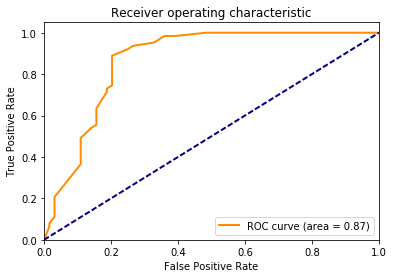

In [31]:
roc_info = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
auc_info = auc(roc_info[0], roc_info[1])
useful.createROCGraph(roc_info[0], roc_info[1], auc_info)

Normalized confusion matrix
[[ 0.81  0.19]
 [ 0.27  0.73]]


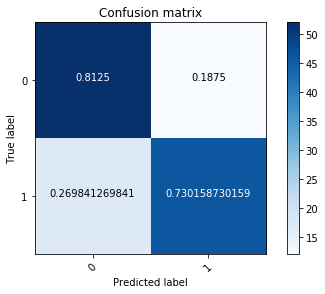

In [32]:
cm = confusion_matrix(y_test, clf.predict(X_test))
useful.plot_confusion_matrix(cm, ["0", "1"])

In [33]:
y_test, clf.predict(X_test)

(array([0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]),
 array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]))

In [34]:
scores = cross_val_score(clf, X, y, cv=10)
print("Cross Fold Mean: %.3f, Cross Fold Stdev: %.3f" % (np.mean(scores), np.std(scores)))

Cross Fold Mean: 0.821, Cross Fold Stdev: 0.085


In [35]:
metrics_dict = metrics.get_all_metrics(y_test, clf.predict(X_test))
print(metrics.pretty_print_metrics(metrics_dict))

accuracy: 0.772

precision: 
	all: ['0.754', '0.793']
	micro: 0.772
	macro: 0.773
	weighted: 0.773
	
recall: 
	all: ['0.812', '0.730']
	micro: 0.772
	macro: 0.771
	weighted: 0.772
	
f1_measure: 
	all: ['0.782', '0.760']
	micro: 0.772
	macro: 0.771
	weighted: 0.771
	
support: 
	y_true_dist: ['0.504', '0.496']
	y_true_count: 127.000
	y_predicted_dist: ['0.543', '0.457']
	y_predicted_count: 127.000
	



In [22]:
clf.feature_importances_

array([ 0.18,  0.04,  0.25,  0.2 ,  0.16,  0.18])

In [178]:
import graphviz

In [179]:
dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                         feature_names=['age', 'gender', 'protein_BL', 'protein_V4', 'protein_V6', 'protein_V8'],  
                         class_names=["not_affected", "affected"],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data, format='pdf')
# graph

In [180]:
graph.render()

'Source.gv.pdf'